In [21]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
%matplotlib inline

In [2]:
images = glob.glob('./camera_cal/calibration*.jpg')
print('Images loaded')

Images loaded


<hr>
<h1>1. Callibration & Undistortion</h1>

In [18]:
#Helper functions
def drawChessBoardCorners(images):
    objpoints = [] 
    imgpoints = []
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    
    for fname in images:
        img = mpimg.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray,(9,6), None)
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            img_chessboard = cv2.drawChessboardCorners(img, (9,6), corners, ret) 
            
    return(img, objpoints, imgpoints)

def undistortImage(image, objpoints, imgpoints, image_shape):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_shape, None, None)
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    return(undistorted, mtx, dist)

Calibrated & Undistorted


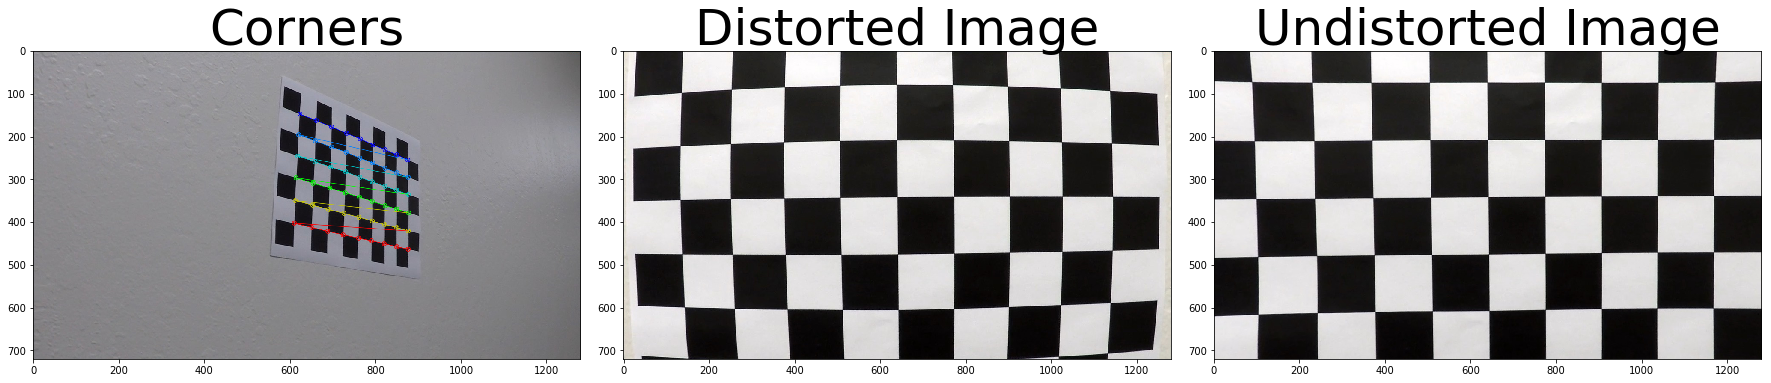

In [19]:
test_image = mpimg.imread(images[0])
chessboardImage, objpoints, imgpoints = drawChessBoardCorners(images)
undistorted, mtx, dist = undistortImage(test_image, objpoints, imgpoints, test_image.shape[1::-1])


f, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(24, 9))
f.tight_layout()
ax1.imshow(chessboardImage)
ax1.set_title('Corners', fontsize=50)
ax2.imshow(test_image)
ax2.set_title('Distorted Image', fontsize=50)
ax3.imshow(undistorted)
ax3.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
print("Calibrated & Undistorted")

<hr>
<h2>2. Color/Gradient threshold</h2>

In [ ]:
#Helper Functions


In [27]:
test_images_path = "./test_images"
test_images = os.listdir(test_images_path)
output_path = "output_images"
print(test_images)

['straight_lines1.jpg', 'straight_lines2.jpg', 'test1.jpg', 'test2.jpg', 'test3.jpg', 'test4.jpg', 'test5.jpg', 'test6.jpg']


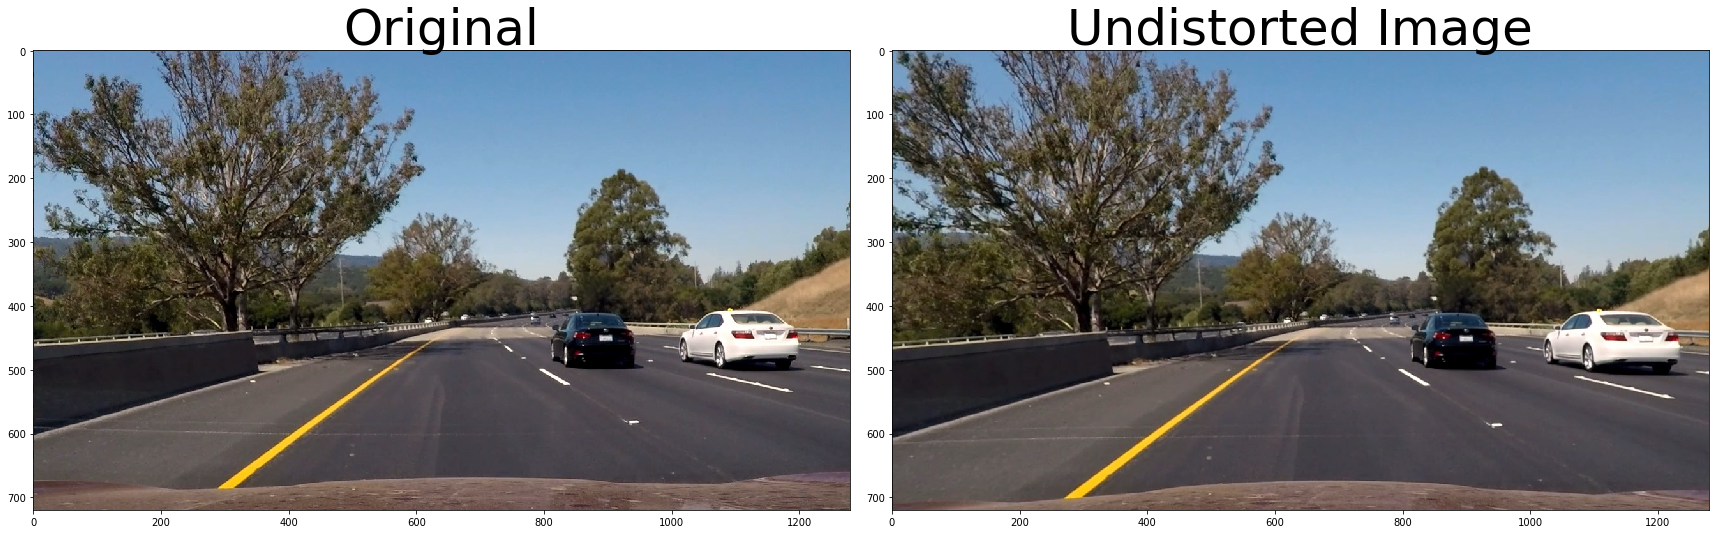

In [31]:
for image in test_images:
    img = mpimg.imread(test_images_path + '/' + image)
    undistorted, mtx, dist = undistortImage(img, objpoints, imgpoints, img.shape[1::-1])
    
f, (ax1,ax2) = plt.subplots(1,2,figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original', fontsize=50)
ax2.imshow(undistorted)
ax2.set_title('Undistorted Image', fontsize=50)